# Face Classification

Our main goal is to be able to make accurate predictions on a face’s age, gender and ethnicity. To achieve this, we will explore ways on how Transfer Learning and splitting the training and testing data among groups affect our results and see if there are any benefits to do so. 

We will also use multiple models - from basic linear regression to neural networks - to achieve the best accuracy. Our main end goal then is to create a functional user interface for anyone to be able to play around with our model.

[age] is an integer from 0 to 116, indicating the age

[gender] is either 0 (male) or 1 (female)

[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern) respectively.

**Note:** 

- The results are all reproducible except for CNNs, training the models will give different results as they use GPUs.
- Sklearn pretrained models can be downloaded [here](https://drive.google.com/drive/folders/16-EhiXckrL2wcrBuGXp9R2EPLX966_VQ). Put them inside 'models' folder.
- CNNs models can be downloaded [here](https://drive.google.com/drive/folders/1xjW43qQZVovoKHC3HZgF23QoimQecdJN) Put them inside 'training' folder.
- Dataset can be downloaded on [Kaggle](https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv).

## Table of content

1. Importing modules
2. Loading Dataset
3. Analyze Distributions
    - Age Distribution
    - Ethnicity Distribution
    - Gender Distribution
    - Inspecting the images
4. Split and Preprocess the data
5. Modelling and Training
    - Decision Trees
    - Random Forests
    - Logistic Regression
    - SVM
    - Neural Networks
6. Transfer Learning
7. Evaluating Models

## 1. Load modules

First, we import some libraries that we're going to use in the notebook. 

**Note**: It is important to have the correct sklearn version to be able to use the saved models.

In [1]:
# !pip install --upgrade scikit-learn==0.23.1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.ensemble
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
import sklearn.metrics
import sklearn.tree
import time
import pickle
import os.path
from PIL import Image
import base64
import io
import cv2
import tensorflow as tf

pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', 50)

# To ensure reproducible results
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
tf.random.set_seed(0)

## 2. Load dataset

Then, we load the dataset containing all the information about age, gender and race. Here is how the data looks like.

**Optional**: If on Google Colab, mount drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# df = pd.read_csv('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/A-FaceClassification/age_gender_race.csv')

df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


As we can see below, there are 23705 images in total and the data looks ready for use.

In [4]:
print(len(df))

23705


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


Let's define some metadata that will be useful afterwards.

In [6]:
GENDER_CATEGORIES = ['Male', 'Female']
RACE_CATEGORIES = ['White', 'Black', 'Asian', 'Indian', 'Others']
IMG_SIZE = 48
LEN_DATASET = 23705

## 3. Analyzing the data

Let's have a look at the distributions of the attributes. For this we will use a histogram.

In [ ]:
def plot_histogram(x, bi, title, xl, yl, nt, tick):
    '''
    Plot histograms from data, bins and labels
    '''
    fig = plt.figure(figsize=(8,8))
    plt.hist(x, bins=bi)
    plt.title(title)
    plt.xlabel(xl)
    plt.ylabel(yl)
    if tick != 0:
        plt.xticks(np.arange(nt), tick)
    plt.show()

### 3a. Age Distribution

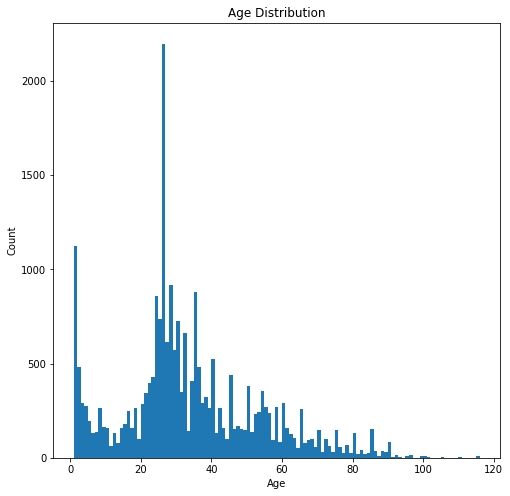

In [ ]:
plot_histogram(df.age, 115, 'Age Distribution', 'Age', 'Count', 0, 0)

As we can see based on this histogram, the age seems to occur the most at 26 and 1 years old.

### 3b. Ethnicity Distribution

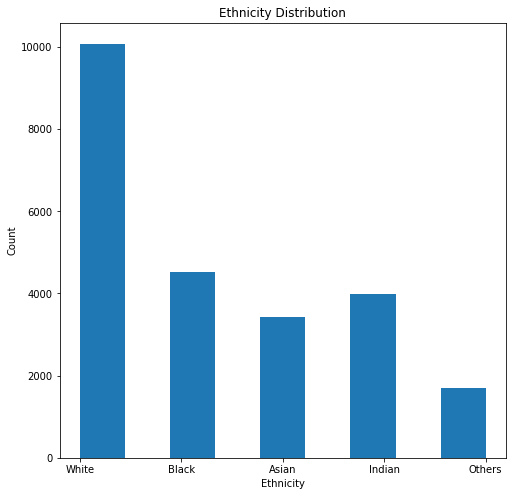

In [ ]:
plot_histogram(df.ethnicity, 9, 'Ethnicity Distribution', 'Ethnicity', 'Count', 5, RACE_CATEGORIES)

As we can see, most people in the dataset are mostly white, while we have less of the 'others' category. (Hispanic, Latino, Middle Eastern) 

This shows that the dataset is quite imbalanced.

### 3c. Gender Distribution

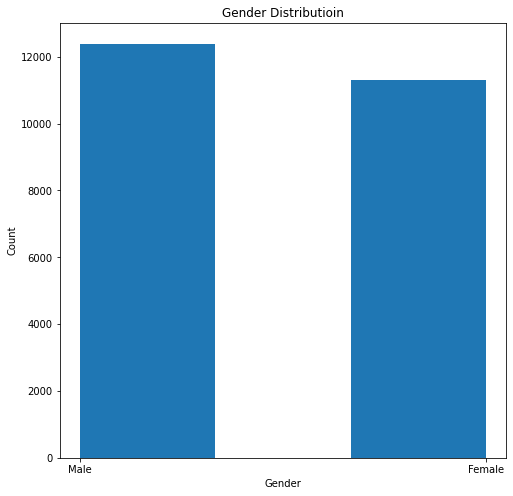

In [ ]:
plot_histogram(df.gender, 3, 'Gender Distributioin', 'Gender', 'Count', 2, GENDER_CATEGORIES)

We can also observe that the data set has slightly more males then females.

### 3d. Inspecting the images

We will now have a look at the images themselves. We start by creating a numpy array X that will contain the pixels of each images. The next line of code will take quite some time since we have to split() the pixels as they are separated by a space.

In [7]:
X = np.array(np.vstack(df.pixels.apply(lambda x: x.split())),dtype='int32')

In [8]:
X

array([[129, 128, 128, ..., 146, 146, 146],
       [164,  74, 111, ..., 182, 170, 148],
       [ 67,  70,  71, ..., 112, 111, 108],
       ...,
       [ 59,  50,  37, ...,  98,  78,  78],
       [ 45, 108, 120, ...,  32,  35,  35],
       [156, 161, 160, ..., 190, 184, 174]], dtype=int32)

Printing 25 random images, we have a look at their attributes. They look green because they are grey-scale images with only one channel.

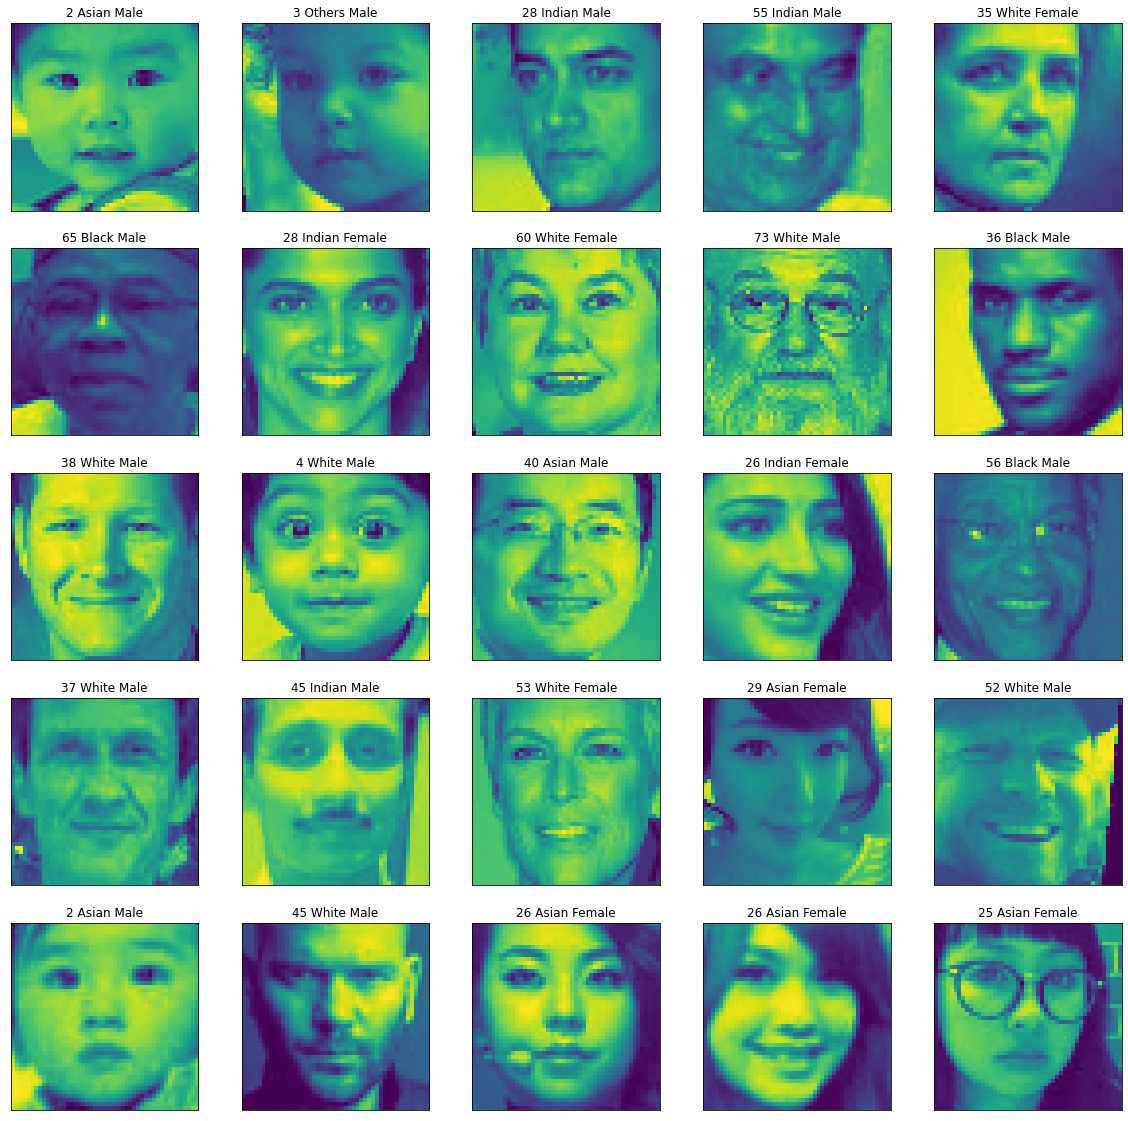

In [ ]:
index = np.random.randint(0,LEN_DATASET,25)

plt.figure(figsize=(20,20))

for i in range(len(index)):
    plt.subplot(5,5,(i%25)+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[index[i]].reshape(IMG_SIZE,IMG_SIZE))
    plt.title(
        f"""{df['age'].iloc[index[i]]} {RACE_CATEGORIES[df['ethnicity'].iloc[index[i]]]} {GENDER_CATEGORIES[df['gender'].iloc[index[i]]]}"""
    )
    
plt.show()

### 3e. Handling imbalanced data

**Optional**: The code below undersamples half of the white persons to balance the data.

In [9]:
l = len(df[df.ethnicity==0])
df = pd.DataFrame().append([df[df.ethnicity==0].sample(int(l/2)),
                           df[df.ethnicity==1],
                           df[df.ethnicity==2],
                           df[df.ethnicity==3],
                           df[df.ethnicity==4]])

In [10]:
X = np.array(np.vstack(df.pixels.apply(lambda x: x.split())),dtype='int32')

In [11]:
df.shape

(18666, 5)

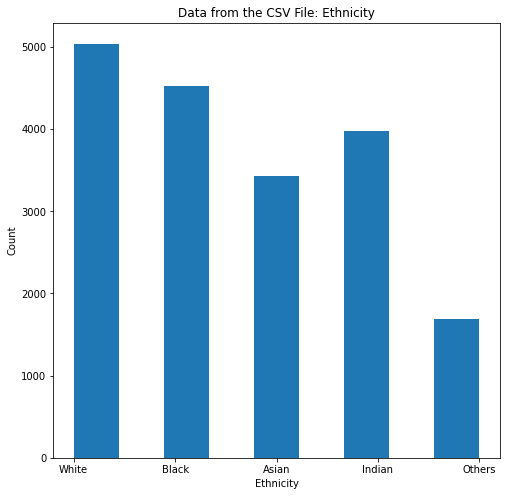

In [ ]:
plot_histogram(df.ethnicity, 9, 'Data from the CSV File: Ethnicity', 'Ethnicity', 'Count', 5, RACE_CATEGORIES)

The data is now less imbalanced. While we have less data now, we will make up for it by augmenting (flipping/ rotating) when training CNNs.

## 4. Split and preprocess the data

To have the data ready for training, we are going to separate them into training and testing. Validation won't be necessary because we are going to use GridSearchCV later on, from which we will split the training data.

Similar to how we obtained X, we are going to create y for the targets being the categories.

In [12]:
y = np.array(df.loc[:, 'age':'gender'].values, dtype='int32')

In [13]:
y

array([[18,  0,  1],
       [61,  0,  1],
       [60,  0,  1],
       ...,
       [ 9,  4,  1],
       [ 9,  4,  1],
       [ 9,  4,  1]], dtype=int32)

We define the targets that will be useful later on.

In [14]:
TARGETS = ['Age', 'Race', 'Gender']
AGE_IDX = 0
RACE_IDX = 1
GENDER_IDX = 2

Using a 80/20 split, we separate training and testing. Since the ethnicity attribute is the most imbalanced one, we stratify on the ethnicity.

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, 
                                                                            test_size=0.2,
                                                                            random_state=RANDOM_SEED,
                                                                            stratify=(y[:,RACE_IDX])
                                                                           )

In [16]:
print(X_train.shape)
print(X_test.shape)

(14932, 2304)
(3734, 2304)


Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem we noramalize them with mean value 0 and standard deviation of 1 using StandardScaler().

In [17]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[ 36.  53.  60. ... 245. 235. 224.]


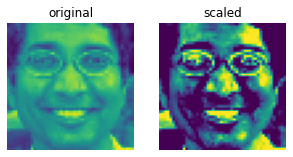

In [18]:
fig = plt.figure(figsize=(5,5))

plt.subplot(121)
original = np.clip(scaler.inverse_transform(X_train[0]),0,255)
print(original)
plt.imshow(original.reshape(IMG_SIZE,IMG_SIZE))
plt.title('original')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.clip(X_train[0],0,1).reshape(48,48))
plt.title('scaled')
plt.axis('off')

plt.show()

As we can see, the pixels have been adjusted.

## 5. Modelling and Training

In this step, we are going to experiment training with different types of models. We intentionally try it on 'bad' models first for comparison.

We now define some functions that will be useful later on.

In [ ]:
def predict(model, data):
        '''
        Different prediction syntax for sklearn and tensorflow models
        '''
        if('GridSearchCV'== model.__class__.__name__):
            return int(model.predict(data.reshape(1,-1))[0])
        else:
            model_out = model.predict(data.reshape(-1,48,48))
            # Ethnicity model gives probability of each category
            if(len(model_out[0])==5):
                return np.argmax(model_out,axis=1)[0]
            else:
                return np.round(model_out[0].flatten()).astype(np.int32)[0]

def test_predict(model, predict_index):
    '''
    It plot 25 random images predictions from the given model and the target index wanted.
    '''
    
    f, ax = plt.subplots(5,5, figsize=(15,15))
        
    index = np.random.randint(0, len(X_test), 25)
    
    for number, i in enumerate(index):
        data = X_test[i]
        
        model_out = predict(model, data)

        if model_out == y_test[i,predict_index]:
            color = 'g'
        else:
            color = 'r'
        
        if(predict_index==GENDER_IDX):
            str_predicted = GENDER_CATEGORIES[model_out]
            str_true = GENDER_CATEGORIES[y_test[i,predict_index]]
        elif(predict_index==RACE_IDX):
            str_predicted = RACE_CATEGORIES[model_out]
            str_true = RACE_CATEGORIES[y_test[i,predict_index]]
        else:
            str_predicted = model_out
            str_true = y_test[i,predict_index]
            
        original = np.clip(scaler.inverse_transform(data),0,255)
        ax[number//5, number%5].imshow(original.reshape(IMG_SIZE,IMG_SIZE))
        ax[number//5, number%5].axis('off')
        ax[number//5, number%5].set_title(f"Pred: {str_predicted} True: {str_true}", {'color' : color})    
    plt.show()

In [ ]:
def fit_model(model, X_train, y_train, cv, parameters, predict_idx):
    '''
    General function to fit model with given cross validation and hyperparameters to the wanted target index.
    
    It also loads the model if it was already saved before or saves the model if not.
    
    It prints the accuracy and the best parameters that the GridSearchCV found.
    '''
    fname = f'models/{predict_idx}-{type(model).__name__}.pkl'
    
    if os.path.isfile(fname):
        # Load from file
        with open(fname, 'rb') as file:
            clf = pickle.load(file)
    else:
        y_train = y_train[:,predict_idx]
        clf = sklearn.model_selection.GridSearchCV(model, parameters, verbose=1, cv=cv, n_jobs=-1)
        clf.fit(X_train, y_train)
        # Save to file
        with open(fname, 'wb') as file:
            pickle.dump(clf, file)
    
    print(f"{TARGETS[predict_idx]} {type(model).__name__}\n")
    if(predict_idx == AGE_IDX):
        print(f"Testing MAE: {sklearn.metrics.mean_absolute_error(y_test[:,AGE_IDX], clf.predict(X_test)):.1f}")
    print(f"Validation score: {clf.best_score_:.1%}")
    print(f"Best params: {clf.best_params_}\n")
    
    return clf

### 5a. Decision Trees

We fit the decision tree model for 10-fold cross validation strategy with different parameters on max_depth.

In [ ]:
params = {'max_depth':[1, 5, 10, 20, 50, 100]}

start_time = time.time()

age_dt_model = fit_model(sklearn.tree.DecisionTreeClassifier(), X_train, y_train, 10, params, AGE_IDX)
gender_dt_model = fit_model(sklearn.tree.DecisionTreeClassifier(), X_train, y_train, 10, params, GENDER_IDX)
race_dt_model = fit_model(sklearn.tree.DecisionTreeClassifier(), X_train, y_train, 10, params, RACE_IDX)

total_time = (time.time() - start_time)

print(f"Running Time: {total_time}")

Age DecisionTreeClassifier

Testing MAE: 14.4
Validation score: 11.7%
Best params: {'max_depth': 5}

Gender DecisionTreeClassifier

Validation score: 73.0%
Best params: {'max_depth': 10}

Race DecisionTreeClassifier

Validation score: 53.3%
Best params: {'max_depth': 10}

Running Time: 0.08044123649597168


As we can see, it performs quite poorly.

### 5b. Random Forests

We fit the random forests model for 10-fold cross validation strategy with different parameters for max_depth.

In [ ]:
param = {'max_depth':[1, 5, 10, 20, 50, 100]}

start_time = time.time()

age_rf_model = fit_model(sklearn.ensemble.RandomForestClassifier(), X_train, y_train, 10, param, AGE_IDX)
gender_rf_model = fit_model(sklearn.ensemble.RandomForestClassifier(), X_train, y_train, 10, param, GENDER_IDX)
race_rf_model = fit_model(sklearn.ensemble.RandomForestClassifier(), X_train, y_train, 10, param, RACE_IDX)

total_time = (time.time() - start_time)

print(f"Running Time: {total_time}")

Age RandomForestClassifier

Testing MAE: 12.7
Validation score: 14.2%
Best params: {'max_depth': 20}

Gender RandomForestClassifier

Validation score: 81.6%
Best params: {'max_depth': 50}

Race RandomForestClassifier

Validation score: 65.7%
Best params: {'max_depth': 20}

Running Time: 2.8502583503723145


It is an improvement on the decision trees.

### 5c. Logistic Regression

We fit the logistic regression model for 10-fold cross validation strategy with different parameters for the inverse of regularization strength, C. The smaller it is the more is the regularization strength.

In [ ]:
param = {'C':[0.0001, 0.001, 0.01, 0.1, 1.0]}

start_time = time.time()

age_lr_model = fit_model(sklearn.linear_model.LogisticRegression(), X_train, y_train, 10, param, AGE_IDX)
gender_lr_model = fit_model(sklearn.linear_model.LogisticRegression(), X_train, y_train, 10, param, GENDER_IDX)
race_lr_model = fit_model(sklearn.linear_model.LogisticRegression(), X_train, y_train, 10, param, RACE_IDX)

total_time = (time.time() - start_time)

print(f"Running Time: {total_time}")

Age LogisticRegression

Testing MAE: 10.5
Validation score: 13.9%
Best params: {'C': 0.001}

Gender LogisticRegression

Validation score: 85.1%
Best params: {'C': 0.01}

Race LogisticRegression

Validation score: 72.3%
Best params: {'C': 0.01}

Running Time: 0.08303523063659668


Till now every model has been an improvement in the validation score compared to the previous one.

### 5d. SVM

We fit the Support Vector Classification model for 10-fold cross validation strategy with different parameters for the inverse of regularization strength, C. Gamma is set at 0.001.

In [ ]:
param = {'C':[0.1, 1, 10, 100, 1000], 'gamma':[0.001]}

start_time = time.time()

age_svm_model = fit_model(sklearn.svm.SVC(), X_train, y_train, 10, param, AGE_IDX)
gender_svm_model = fit_model(sklearn.svm.SVC(), X_train, y_train, 10, param, GENDER_IDX)
race_svm_model = fit_model(sklearn.svm.SVC(), X_train, y_train, 10, param, RACE_IDX)

total_time = (time.time() - start_time)

print(f"Running Time: {total_time}")

Age SVC

Testing MAE: 11.5
Validation score: 14.4%
Best params: {'C': 1, 'gamma': 0.001}

Gender SVC

Validation score: 86.7%
Best params: {'C': 10, 'gamma': 0.001}

Race SVC

Validation score: 74.3%
Best params: {'C': 10, 'gamma': 0.001}

Running Time: 433.5009129047394


SVM by far took the most time to train but had slightly better results that logistic regression except for the Age.

Let's see how it performs.

In [ ]:
X_test[0].shape

(2304,)

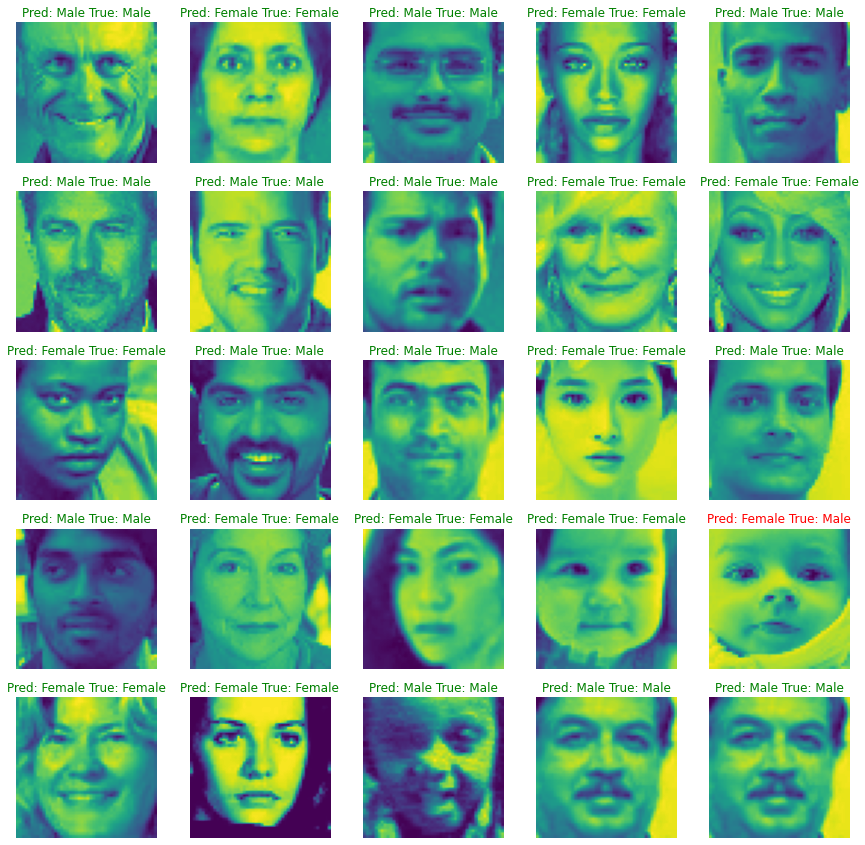

In [ ]:
test_predict(gender_svm_model, GENDER_IDX)

The gender predictions are not so bad.

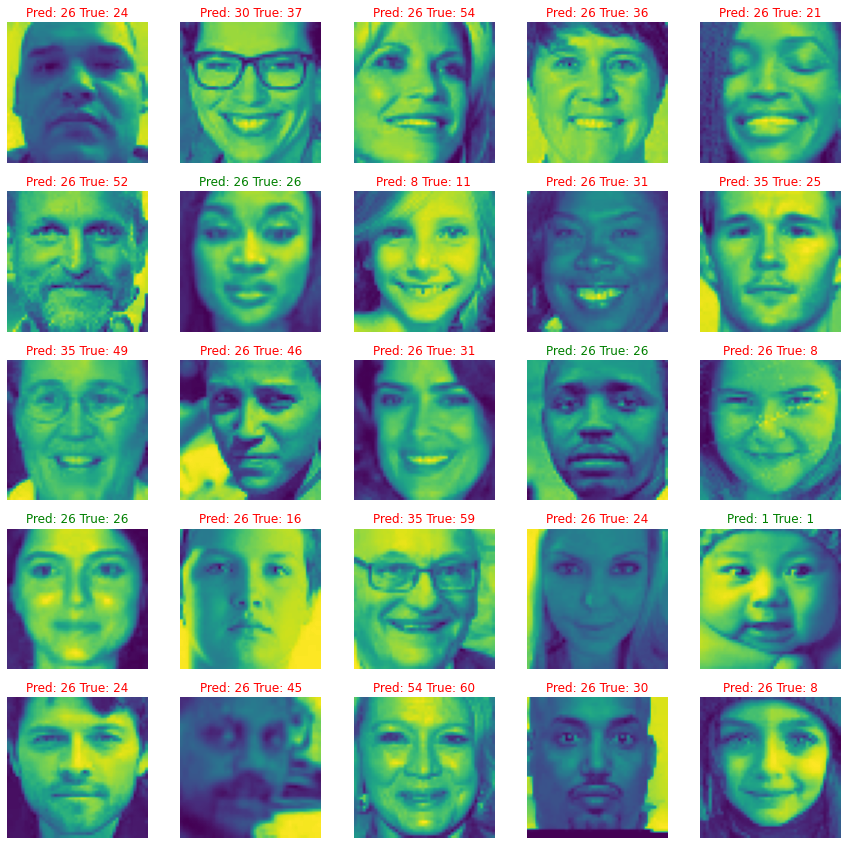

In [ ]:
test_predict(age_svm_model, AGE_IDX)

As for the age, it has been heavily influenced by the imbalance in ages in the distributions, most of the predictions are 26 and 1 years old.

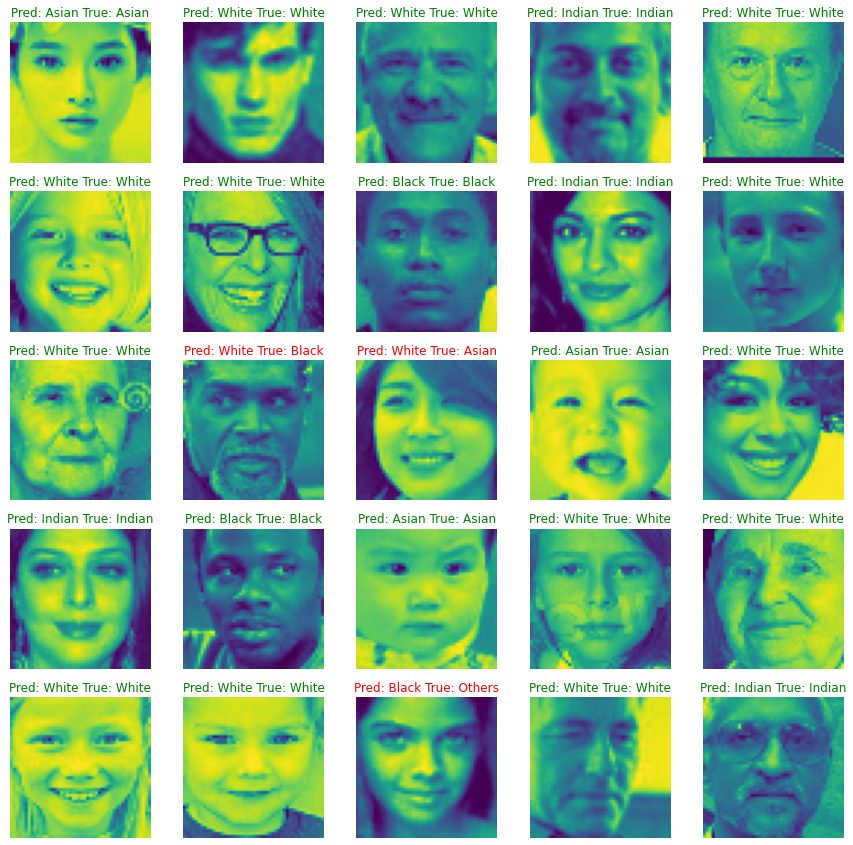

In [ ]:
test_predict(race_svm_model, RACE_IDX)

For the ethnicity results, it is not doing so bad.

### 5e. Neural Networks

We are now going to train the data with a Convolutional Neural Network. It is the one that will most likely perform the best out of all the models. We start by defining a general function that will help us create the model.

After some trial and error, adam optimizer was found to be the quickest while giving a pretty good accuracy.

In [36]:
tf.random.set_seed(0)

def build_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy', metrics='accuracy'):
    '''
    Creates a CNN with num_classes, activation, loss and metrics as arguments. These will help make the
    different models.
    '''
    
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    x = inputs

    # Augment the data by randomly flipping and rotating the images
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(x)
    # x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=[metrics]        
    )
    
    return model

### 1. Gender Model

For the gender, since there are only two classes, we make use of a binary_crossentropy as loss function. We don't use softmax because the sum of outputs does not necessarily add up to 1 as well. Indeed after trying with softmax and sigmoid, we found that sigmoid performs better.

In [37]:
gender_cnn_model = build_model(1, activation='sigmoid', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

checkpoint_path = "training/cp-cnn-gender.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

Here is a summary of the CNN.

In [38]:
gender_cnn_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 128)      

**Optional**: To restore the weights from the checkpoints, run the next cell.

In [39]:
# gender_cnn_model.load_weights(checkpoint_path)

To train the model, run the next cell.

In [40]:
gender_history = gender_cnn_model.fit(
    X_train.reshape(-1,48,48),
    y_train[:,GENDER_IDX].reshape(-1),
    validation_split=0.2,
    batch_size=64,
    epochs=30,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.2, patience=4,
                                                    min_lr=0.001, verbose=1),
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8,
                                                verbose=1, mode='auto',
                                                restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)],
    verbose=1
)

Epoch 1/30
186/187 [============================>.] - ETA: 0s - loss: 0.6277 - accuracy: 0.7357
Epoch 00001: val_loss improved from inf to 0.71388, saving model to training/cp-cnn-gender.ckpt
187/187 [==============================] - 4s 19ms/step - loss: 0.6275 - accuracy: 0.7360 - val_loss: 0.7139 - val_accuracy: 0.6254
Epoch 2/30
187/187 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.8202
Epoch 00002: val_loss improved from 0.71388 to 0.59094, saving model to training/cp-cnn-gender.ckpt
187/187 [==============================] - 3s 18ms/step - loss: 0.5877 - accuracy: 0.8202 - val_loss: 0.5909 - val_accuracy: 0.8447
Epoch 3/30
186/187 [============================>.] - ETA: 0s - loss: 0.5774 - accuracy: 0.8432
Epoch 00003: val_loss improved from 0.59094 to 0.57748, saving model to training/cp-cnn-gender.ckpt
187/187 [==============================] - 3s 18ms/step - loss: 0.5772 - accuracy: 0.8434 - val_loss: 0.5775 - val_accuracy: 0.8594
Epoch 4/30
184/187 [

Having a look at the testing accuracy. We obtain 89%, which is the best score we had so far.

In [41]:
gender_acc = gender_cnn_model.evaluate(X_test.reshape(-1,48,48), y_test[:,GENDER_IDX])[1]

117/117 [==============================] - 1s 4ms/step - loss: 0.5644 - accuracy: 0.8926


Let's now take a look at the learning curves.

In [42]:
gender_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

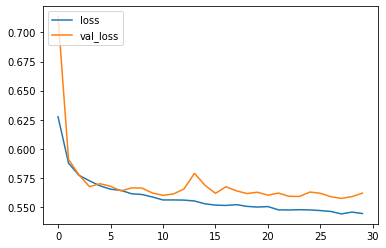

In [43]:
plt.plot(gender_history.history['loss'], label='loss')
plt.plot(gender_history.history['val_loss'], label='val_loss')
plt.legend(loc="upper left")
plt.show()

From the val_loss, we can observe we were quickly overfitting the model. Hence why the EarlyStopping callback stopped the training and restored the best weights.

### 2. Age model

Now training for the Age, our loss function is set at mean_squared_error and we have mean absolute error as metric. That's because it is better than accuracy, since we're more concerned how far off our prediction is from the real age. 

For example predicting 25 instead of 30 is not that bad, with a MAE of 5.

In [44]:
age_cnn_model = build_model(1, activation='relu', loss='mean_squared_error', metrics='mae')

checkpoint_path = "training/cp-cnn-age.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

Let's have a look at the model.

In [45]:
age_cnn_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 128)      

**Optional**: To restore the weights from the checkpoints, run the next cell.

In [46]:
# age_cnn_model.load_weights(checkpoint_path)

To train the model, run the next cell.

In [47]:
age_history = age_cnn_model.fit(
    X_train.reshape(-1,48,48),
    y_train[:,AGE_IDX].reshape(-1),
    validation_split=0.2,
    batch_size=64,
    epochs=30,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.2, patience=4,
                                                    min_lr=0.001, verbose=1),
               tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=8,
                                                verbose=1, mode='auto',
                                                restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)],
    verbose=1
)

Epoch 1/30
184/187 [============================>.] - ETA: 0s - loss: 844.5451 - mae: 23.9937
Epoch 00001: val_loss improved from inf to 2192.30347, saving model to training/cp-cnn-age.ckpt
187/187 [==============================] - 4s 19ms/step - loss: 841.0196 - mae: 23.9452 - val_loss: 2192.3035 - val_mae: 43.6667
Epoch 2/30
185/187 [============================>.] - ETA: 0s - loss: 329.8030 - mae: 13.8488
Epoch 00002: val_loss improved from 2192.30347 to 2062.76758, saving model to training/cp-cnn-age.ckpt
187/187 [==============================] - 3s 18ms/step - loss: 328.3284 - mae: 13.8093 - val_loss: 2062.7676 - val_mae: 42.5213
Epoch 3/30
187/187 [==============================] - ETA: 0s - loss: 154.2317 - mae: 9.0821
Epoch 00003: val_loss improved from 2062.76758 to 219.76979, saving model to training/cp-cnn-age.ckpt
187/187 [==============================] - 3s 18ms/step - loss: 154.2317 - mae: 9.0821 - val_loss: 219.7698 - val_mae: 11.8045
Epoch 4/30
184/187 [=============

Having a look at the testing accuracy. We have a MAE of roughly 6 years old.

In [48]:
age_mae = age_cnn_model.evaluate(X_test.reshape(-1,48,48), y_test[:,AGE_IDX])[1]

117/117 [==============================] - 1s 4ms/step - loss: 73.3245 - mae: 6.0835


Learning curves are plotted.

In [49]:
age_history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

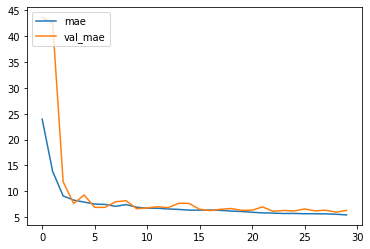

In [50]:
plt.plot(age_history.history['mae'], label='mae')
plt.plot(age_history.history['val_mae'], label='val_mae')
plt.legend(loc="upper left")
plt.show()

### 3. Race model

For the race model, we use a sparse_categorical_crossentropy loss as it is a multiclassification problem (5 ethnicities).

In [61]:
race_cnn_model = build_model(5, activation='softmax', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_path = "training/cp-cnn-race.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

Here is the model summary.

In [62]:
race_cnn_model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
random_flip_7 (RandomFlip)   (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 128)     

**Optional**: To restore the weights from the checkpoints, run the next cell.

In [63]:
# race_cnn_model.load_weights(checkpoint_path)

To train the model, we run the next cell.

In [64]:
race_history = race_cnn_model.fit(
    X_train.reshape(-1,48,48),
    y_train[:,RACE_IDX].reshape(-1),
    validation_split=0.2,
    batch_size=64,
    epochs=30,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.2, patience=4,
                                                    min_lr=0.001, verbose=1),
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8,
                                                verbose=1, mode='auto',
                                                restore_best_weights=True),
               tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)],
    verbose=1
)

Epoch 1/30
186/187 [============================>.] - ETA: 0s - loss: 1.4759 - accuracy: 0.4468
Epoch 00001: val_loss improved from inf to 2.07135, saving model to training/cp-cnn-race.ckpt
187/187 [==============================] - 4s 19ms/step - loss: 1.4745 - accuracy: 0.4471 - val_loss: 2.0714 - val_accuracy: 0.2718
Epoch 2/30
184/187 [============================>.] - ETA: 0s - loss: 1.0296 - accuracy: 0.6225
Epoch 00002: val_loss improved from 2.07135 to 1.74756, saving model to training/cp-cnn-race.ckpt
187/187 [==============================] - 3s 18ms/step - loss: 1.0301 - accuracy: 0.6229 - val_loss: 1.7476 - val_accuracy: 0.3612
Epoch 3/30
184/187 [============================>.] - ETA: 0s - loss: 0.8905 - accuracy: 0.6788
Epoch 00003: val_loss improved from 1.74756 to 0.81612, saving model to training/cp-cnn-race.ckpt
187/187 [==============================] - 3s 18ms/step - loss: 0.8884 - accuracy: 0.6793 - val_loss: 0.8161 - val_accuracy: 0.7017
Epoch 4/30
184/187 [======

As for the accuracy of the CNN, we now have have 79% accuracy compared to the svm's accuracy of 74%.  

In [65]:
race_acc = race_cnn_model.evaluate(X_test.reshape(-1,48,48), y_test[:,RACE_IDX])[1]

117/117 [==============================] - 0s 4ms/step - loss: 0.7167 - accuracy: 0.7807


In [66]:
race_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

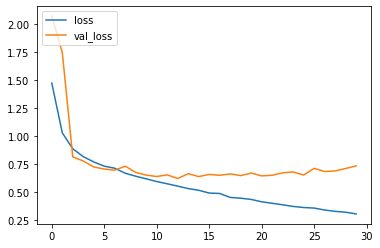

In [67]:
plt.plot(race_history.history['loss'], label='loss')
plt.plot(race_history.history['val_loss'], label='val_loss')
plt.legend(loc="upper left")
plt.show()

## 6. Transfer Learning

We are now going to try a very interesting concept - Transfer Learning. Basically, we make use of a model, pretrained on images. Since first layers in a neural network is mostly very generalized features, we can make use of the 'bottom' of the neural network and use the top layers for our classification purpose.

Since the pretrained model we will be using takes in 3 input channels, we're going to repeat the gray scale 3 times to mimic this.

In [68]:
X_train_rgb = np.repeat(X_train.reshape(-1,48,48)[..., np.newaxis], 3, -1)
print(X_train.reshape(-1,48,48).shape)
print(X_train_rgb.shape)

(14932, 48, 48)
(14932, 48, 48, 3)


Also, we're going to need to create our validation dataset manually this time.

In [69]:
X_train_rgb, X_val_rgb, y_train_rgb, y_val_rgb = sklearn.model_selection.train_test_split(X_train_rgb, y_train, test_size=0.2)

We then load the pretrained ResNet50 model, specifying the dimensions of our input. Notice the include_top argument, we're loading a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [70]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)

base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


We then convert our training and validation dataset to tensors.

In [71]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_rgb.reshape(-1,48,48,3), y_train_rgb[:,GENDER_IDX]))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_rgb.reshape(-1,48,48,3), y_val_rgb[:,GENDER_IDX]))

Next, we use buffered prefetching to load images from disk for better performance.

In [72]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [73]:
train_dataset

<BatchDataset shapes: ((None, 48, 48, 3), (None,)), types: (tf.float64, tf.int32)>

This feature extractor converts each 48x48x3 image into a 2x2x1280 block of features. Let's see what it does to an example batch of images:

In [74]:
@tf.function
def input_fn(train_dataset):
    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    return image_batch, feature_batch

image_batch, feature_batch = input_fn(train_dataset)

From this step, we are going to freeze the convolutional model base created in the previous steps and to use as a feature extractor. Basically, it means that the weights will not be updated.

In [75]:
base_model.trainable = False

In [76]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

As seen above, all the parameters are non-trainable. We are only going to train the top-level classifier, which we will add to it.

**Adding the Classification Head**

Similar with training CNN, since we don't have a lot of data, we are going to augment it by flipping and rotating the images.




In [77]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

To generate predictions from the block of features we average over spatial locations using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.

In [78]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


Next, we define our last prediction layer.

In [79]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


Putting everything together and compiling.

In [80]:
gender_tl_model = None

In [81]:
inputs = tf.keras.Input(shape=(48, 48, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
gender_tl_model = tf.keras.Model(inputs, outputs)

In [88]:
base_learning_rate = 0.01
gender_tl_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Here is a summary, as we can see, we are training 2049 parameters, which comes only from the last layer.

In [83]:
gender_tl_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 48, 48, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)               

Out of the 2049 parameters, they are divided into two tensors, the weights and the biases.

In [84]:
len(gender_tl_model.trainable_variables)

2

Next, let's actually train the model.

In [85]:
checkpoint_path = "training/cp-tl-gender.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

**Optional**: To restore the weights from the checkpoints, run the next cell.

In [86]:
# gender_tl_model.load_weights(checkpoint_path)

To train the model, run the next cell. We initially train for 20 epochs only before fine-tuning.

In [89]:
initial_epochs = 20

history = gender_tl_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)]
                   )

Epoch 1/20
186/187 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.6394
Epoch 00001: val_loss improved from inf to 0.64295, saving model to training/cp-tl-gender.ckpt
187/187 [==============================] - 6s 30ms/step - loss: 0.6551 - accuracy: 0.6392 - val_loss: 0.6429 - val_accuracy: 0.6689
Epoch 2/20
185/187 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6480
Epoch 00002: val_loss improved from 0.64295 to 0.64097, saving model to training/cp-tl-gender.ckpt
187/187 [==============================] - 5s 26ms/step - loss: 0.6521 - accuracy: 0.6473 - val_loss: 0.6410 - val_accuracy: 0.6806
Epoch 3/20
187/187 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6527
Epoch 00003: val_loss improved from 0.64097 to 0.64079, saving model to training/cp-tl-gender.ckpt
187/187 [==============================] - 5s 27ms/step - loss: 0.6502 - accuracy: 0.6527 - val_loss: 0.6408 - val_accuracy: 0.6913
Epoch 4/20
187/187 [===

The validation accuracy went up only to 71% here, compared to 90% that we had previously with the CNN, it is doing pretty bad.

**Fine Tuning**

To increase performance, we are going to further train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. 

We are unfreezing the whole model and freezing only the layers we don't want to train. Arbitrarily, we will train from layer 100 onwards.

In [90]:
base_model.trainable = True

In [91]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  175


Since it has 175 layers in total, we're going to train 75 layers. In fine-tuning, we are decreasing the base learning rate as we can quickly overfit the model.

In [92]:
gender_tl_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [93]:
gender_tl_model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 48, 48, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 48, 48, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)               

As we can see above, we are now training way more parameters.

In [94]:
checkpoint_path = "training/cp-tlft-gender.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

**Optional**: To restore the weights from the checkpoints, run the next cell.

In [95]:
# gender_tl_model.load_weights(checkpoint_path)

In [96]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = gender_tl_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)
                         )

Epoch 20/30
187/187 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5136
Epoch 00020: val_loss improved from inf to 0.69315, saving model to training/cp-tlft-gender.ckpt
187/187 [==============================] - 11s 58ms/step - loss: 0.6929 - accuracy: 0.5136 - val_loss: 0.6931 - val_accuracy: 0.5186
Epoch 21/30
186/187 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5128
Epoch 00021: val_loss did not improve from 0.69315
187/187 [==============================] - 9s 50ms/step - loss: 0.6931 - accuracy: 0.5127 - val_loss: 0.6931 - val_accuracy: 0.5186
Epoch 22/30
187/187 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5127
Epoch 00022: val_loss did not improve from 0.69315
187/187 [==============================] - 9s 51ms/step - loss: 0.6931 - accuracy: 0.5127 - val_loss: 0.6931 - val_accuracy: 0.5186
Epoch 23/30
186/187 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5128
Epoch 00023: val

Unfortunately, it seemed to have reached a local minima and was not able to give a better result than before fine-tuning. 

Since Transfer Learning did badly, we did not go any further with predicting age and race.

## 7. Evaluating Models

In this section, we'll try to draw out conclusions from the models trained and compare their results. 

We define a function plot_confusion_matrix so we're able to plot tensorflow predictions and not only sklearn models.



In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, predict_idx):
    '''
    Plot confusion matrix from y_true and y_pred with labels.
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cm = sklearn.metrics.confusion_matrix(y_test[:,predict_idx], y_pred)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.show()

**Comparing best gender models**

In [ ]:
y_pred = np.round(gender_cnn_model.predict(X_test.reshape(-1,48,48)).flatten()).astype(np.int32)

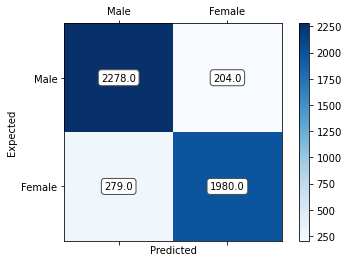

In [ ]:
plot_confusion_matrix(y_test[:,GENDER_IDX], y_pred, GENDER_CATEGORIES, GENDER_IDX)

In [ ]:
print(sklearn.metrics.classification_report(y_test[:,GENDER_IDX],y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2482
           1       0.91      0.88      0.89      2259

    accuracy                           0.90      4741
   macro avg       0.90      0.90      0.90      4741
weighted avg       0.90      0.90      0.90      4741



The next line of code will take some minutes. Since we had a pretty big training, there might be a lot of support vectors.

In [ ]:
y_pred = gender_svm_model.predict(X_test.reshape(-1,IMG_SIZE*IMG_SIZE))

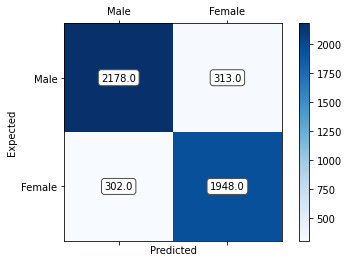

In [ ]:
plot_confusion_matrix(y_test[:,GENDER_IDX], y_pred, GENDER_CATEGORIES, GENDER_IDX)

In [ ]:
print(sklearn.metrics.classification_report(y_test[:,GENDER_IDX],y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2491
           1       0.86      0.87      0.86      2250

    accuracy                           0.87      4741
   macro avg       0.87      0.87      0.87      4741
weighted avg       0.87      0.87      0.87      4741



As expected, the CNN model are some numbers ahead of the SVM model.

**Comparing best age models**

Let's have a look by plotting the scatter of the expected age and prediction age. Ideally, we want the predictions to be on a 45 degree line, y = x, plotted in orange.

In [ ]:
y_cnn_pred = np.round(age_cnn_model.predict(X_test.reshape(-1,48,48)).flatten()).astype(np.int32)
y_svm_pred = age_svm_model.predict(X_test.reshape(-1, IMG_SIZE*IMG_SIZE))
y_lr_pred = age_lr_model.predict(X_test.reshape(-1, IMG_SIZE*IMG_SIZE))

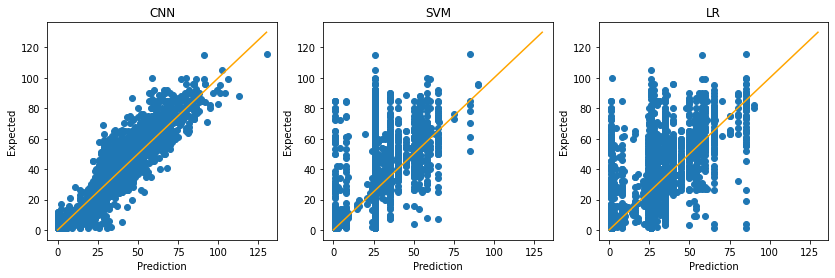

In [ ]:
fig = plt.figure(figsize=(14,4))

x = np.linspace(0, 130, 1000)

plt.subplot(131)
plt.plot(x,x, linestyle='solid', c= "orange")
plt.scatter(y_cnn_pred, y_test[:,AGE_IDX])
plt.xlabel('Prediction')
plt.ylabel('Expected')
plt.title('CNN')

plt.subplot(132)
plt.plot(x,x, linestyle='solid', c= "orange")
plt.scatter(y_svm_pred, y_test[:,AGE_IDX])
plt.xlabel('Prediction')
plt.ylabel('Expected')
plt.title('SVM')

plt.subplot(133)
plt.plot(x,x, linestyle='solid', c= "orange")
plt.scatter(y_lr_pred, y_test[:,AGE_IDX])
plt.xlabel('Prediction')
plt.ylabel('Expected')
plt.title('LR')
plt.show()

The CNN clearly was able to make predictions along the line. The SVM and LR, however, were very far off. The SVM and LR were heavily biased with the data distributions with most of the predictions at 26 years old and almost none of them at 90+ years old.

**Comparing best ethnicity models**

In [ ]:
y_cnn_pred = np.argmax(race_cnn_model.predict(X_test.reshape(-1,48,48)),axis=1)
y_svm_pred = race_svm_model.predict(X_test.reshape(-1, IMG_SIZE*IMG_SIZE))

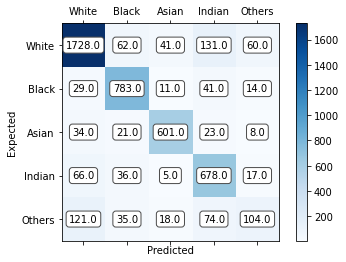

In [ ]:
plot_confusion_matrix(y_test[:,RACE_IDX], y_cnn_pred, RACE_CATEGORIES, RACE_IDX)

In [ ]:
print(sklearn.metrics.classification_report(y_test[:,RACE_IDX],y_pred))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78      1008
           1       0.84      0.87      0.86       905
           2       0.89      0.81      0.85       687
           3       0.74      0.78      0.76       795
           4       0.48      0.20      0.28       339

    accuracy                           0.77      3734
   macro avg       0.73      0.70      0.71      3734
weighted avg       0.76      0.77      0.76      3734



As expected, the 'others' ethnicity category performed the worse amond all of them.

In [ ]:
y_pred = race_svm_model.predict(X_test.reshape(-1, IMG_SIZE*IMG_SIZE))

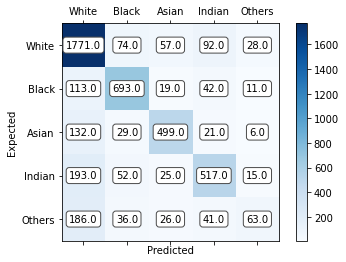

In [ ]:
plot_confusion_matrix(y_test[:,RACE_IDX], y_pred, RACE_CATEGORIES, RACE_IDX)

In [ ]:
print(sklearn.metrics.classification_report(y_test[:,RACE_IDX],y_pred))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80      2022
           1       0.78      0.79      0.79       878
           2       0.80      0.73      0.76       687
           3       0.73      0.64      0.68       802
           4       0.51      0.18      0.27       352

    accuracy                           0.75      4741
   macro avg       0.71      0.64      0.66      4741
weighted avg       0.74      0.75      0.73      4741



**Error Analysis**

We will analyze the errors visually, as they can help us to determine how to best tune some parameters or reveal some of the impact of the data had on our training.

In [ ]:
y_pred = np.round(gender_cnn_model.predict(X_test.reshape(-1,48,48)).flatten()).astype(np.int32)

In [ ]:
error_index = (y_test[:,GENDER_IDX] != y_pred) # finding error indices
y_test_error = y_test[error_index]
X_test_error = X_test[error_index]
prediction_error = y_pred[error_index]

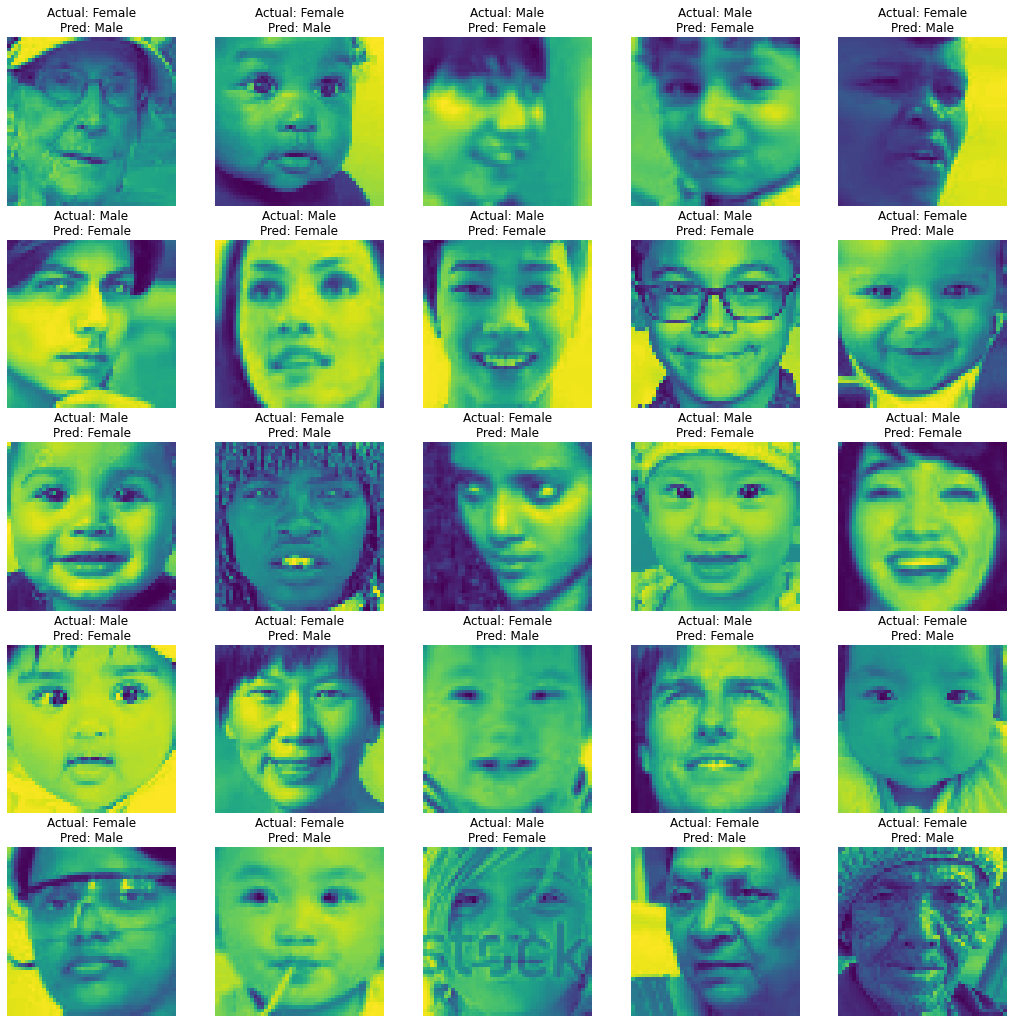

In [ ]:
rows = 5
cols = 5
x_samp = X_test_error
y_samp = y_test_error[:,GENDER_IDX]

fig,ax = plt.subplots(rows, cols, figsize=(18,18))
r = 0
c = 0

for i in range((rows*cols)):
    original = np.clip(scaler.inverse_transform(x_samp[i]),0,255)
    aa = original.reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa)
    actual_lab = "Female" if y_samp[i,] == 1 else "Male"
    pred_lab = "Female" if int(prediction_error[i]) == 1 else "Male"
    ax[r,c].set_title(f'Actual: {actual_lab}\nPred: {pred_lab}')
    c+=1
    if c == cols:
        c=0
        r+=1

plt.show()

We can observe that most of the errors are babies and are indeed pretty hard to identify.

# Try it out - take a selfie! 😁

Where's the fun of building a face classifier if we're not trying it on ourselves huh? ;)

We define two functions below: rgb2gray and single_image_predict.

This part works only in jupyter notebook.

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def single_image_predict(models, image):
    '''
    models [age, gender, race]
    image 48x48 
    '''
    plt.imshow(image)
    image = rgb2gray(image)
    data = scaler.transform(image.reshape(1,-1))
    age_pred = predict(models[0],data)
    gender_pred = GENDER_CATEGORIES[predict(models[1],data)]
    race_pred = RACE_CATEGORIES[predict(models[2],data)]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Age: {age_pred}  Gender: {gender_pred}  Ethnicity: {race_pred}")
    plt.show()

In [36]:
from IPython.display import HTML

main_text = """

<input type="button" onclick="javascript:code_toggle()" value="Toggle code" style="display:inline"/>
<button id="snap">Snap Photo</button>
<div>
<video id="video" width="240" height="240" autoplay></video>
<canvas id="canvas" width="240" height="240"></canvas>
<canvas style="display:none" id="canvas2" width="48" height="48"></canvas>
</div>

<script>
// Grab elements, create settings, etc.
var video = document.getElementById('video');

// Get access to the camera!
if(navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
    // Not adding `{ audio: true }` since we only want video now
    navigator.mediaDevices.getUserMedia({ video: true }).then(function(stream) {
        //video.src = window.URL.createObjectURL(stream);
        //video.play();
        video.srcObject=stream;
        video.play();
    });
}

// Elements for taking the snapshot
var canvas = document.getElementById('canvas');
var context = canvas.getContext('2d');
var canvas2 = document.getElementById('canvas2');
var context2 = canvas2.getContext('2d');
var video = document.getElementById('video');

// Trigger photo take
document.getElementById("snap").addEventListener("click", function() {
    context.drawImage(video, 0, 0, 240, 240);
    context2.drawImage(video, 0, 0, 48, 48);
    var myCanvas2 = document.getElementById('canvas2');
    var image = myCanvas2.toDataURL("image/png");
    IPython.notebook.kernel.execute("print('testing')")
    IPython.notebook.kernel.execute("image = '" + image + "'")
});

code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);

</script>
"""
HTML(main_text)


In [34]:
pil_im = Image.open(io.BytesIO(base64.b64decode(image.split(',')[1])))
selfie = np.array(pil_im)[:,:,0:3]
single_image_predict([age_cnn_model,gender_svm_model,race_cnn_model], selfie)

## Just for fun! 😁

Put your custom face images in a folder called 'demo' and see the results!

In [ ]:
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

def demo_image_predict(models):
    '''
    models [age, gender, race]
    image 48x48 
    '''
    f, ax = plt.subplots(1,5, figsize=(20,20))

    images = load_images_from_folder('demo')
    
    for i, image in enumerate(images):
        image = cv2.resize(image, dsize=(120, 120), interpolation=cv2.INTER_CUBIC)
        ax[i%5].imshow(image)
        image = cv2.resize(image, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
        image = rgb2gray(image)
        data = scaler.transform(image.reshape(1,-1))
        age_pred = predict(models[0], data)
        gender_pred = GENDER_CATEGORIES[predict(models[1], data)]
        race_pred = RACE_CATEGORIES[predict(models[2], data)]

        ax[i%5].grid(False)
        ax[i%5].axis('off')
        ax[i%5].set_title(f"Age: {age_pred}\n  Gender: {gender_pred}\n  Ethnicity: {race_pred}")
    plt.show()

In [35]:
demo_image_predict([age_cnn_model,gender_cnn_model,race_svm_model])

## References

1. https://www.tensorflow.org/tutorials/images/transfer_learning

2. https://www.tensorflow.org/tutorials/images/data_augmentation

3. https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv

4. https://colbrydi.github.io/accessing-a-computers-camera-inside-of-jupyter-without-installing-opencv-also-works-in-jupyterhub.html